In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import copy

from skimage.io import imread
from skimage.transform import resize
%matplotlib inline

In [46]:
!wget https://i.ytimg.com/vi/YWSRRK6gar8/hqdefault.jpg -O style.jpg
#!wget http://static.biblioclub.ru/art_portal/pictures/491/491655/mone092_catpage.jpg -O style.jpg
!wget http://static.biblioclub.ru/art_portal/pictures/491/491655/mone092_catpage.jpg -O original.jpg

--2018-07-16 03:31:20--  https://i.ytimg.com/vi/YWSRRK6gar8/hqdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 74.125.202.119, 173.194.74.119, 173.194.193.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|74.125.202.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30568 (30K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>]  29.85K  --.-KB/s    in 0s      

2018-07-16 03:31:20 (79.6 MB/s) - ‘style.jpg’ saved [30568/30568]

--2018-07-16 03:31:20--  http://static.biblioclub.ru/art_portal/pictures/491/491655/mone092_catpage.jpg
Resolving static.biblioclub.ru (static.biblioclub.ru)... 93.191.13.234
Connecting to static.biblioclub.ru (static.biblioclub.ru)|93.191.13.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217583 (212K) [image/jpeg]
Saving to: ‘original.jpg’

original.jpg        100%[===================>] 212.48K   294KB/s    in 0.7s    

2018-07-16 03:31:22 (294 KB/s) - ‘original.jpg’ saved

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


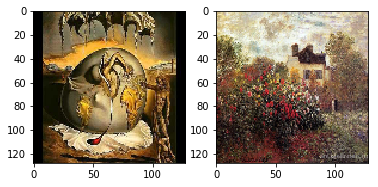

In [47]:
def readimg(path,size):
    image = resize(imread(path),size).astype(np.float32)
    image = (image-image.min())/(image.max()-image.min())
    if 2==len(image.shape):
        image = np.dstack([image,image,image])
    return np.expand_dims(image.transpose(2,0,1),0)

def imshow(style,content, title=None):
    f,ax = plt.subplots(1,2)
    ax[0].imshow(style.numpy()[0].transpose(1,2,0))
    ax[1].imshow(content.numpy()[0].transpose(1,2,0))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

style_img = torch.from_numpy(readimg("style.jpg",(128,128)).astype(np.float32))
content_img = torch.from_numpy(readimg("original.jpg",(128,128)).astype(np.float32))
imshow(style_img,content_img)



Задача 1. Вычисление марицы Грамма.
Мартица грамма должна получиться размером DxD, где D - количество признаков
Матрица грамма отражает корреляции между признакми в выборке.

In [43]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=размер батча
    # b=размер пространства признаков
    # (c,d)=размеры изображения. map (N=c*d)

    features = input.view(a * b, c * d)  #Получаетм вектор [количество признаков, элементы]

    #TODO: расчитать матрицу грамма
   
    G = torch.mm(features,features.t())
    # Нормировка 
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return self.loss
        
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return self.loss

In [13]:
#Загружаем веса VGG16 и переопределяем граф вычислений, чтобы получать только выходы с 5 сверточных слоев
class MyVGG(nn.Module):
    def __init__(self,pretrained=True):
        super(MyVGG, self).__init__()
        self.mean = Variable(torch.FloatTensor([0.485, 0.456, 0.406]).view(-1, 1, 1))
        self.std = Variable(torch.FloatTensor([0.229, 0.224, 0.225]).view(-1, 1, 1))
        self.vgg = torchvision.models.vgg16(pretrained=True)
    def forward(self,x):
        # Слой для нормировки изображений
        x = (x - self.mean) / self.std
        conv_1 = self.vgg.features[0](x)
        x = self.vgg.features[1](conv_1)
        conv_2 = self.vgg.features[2](x)
        x = self.vgg.features[3](conv_2)
        x = self.vgg.features[4](x)
        conv_3 = self.vgg.features[5](x)
        x = self.vgg.features[6](conv_3 )
        conv_4 = self.vgg.features[7](x)
        x = self.vgg.features[8](conv_4)
        x = self.vgg.features[9](x)
        conv_5 = self.vgg.features[10](x)
        return conv_1,conv_2,conv_3,conv_4,conv_5
    
vgg = MyVGG()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/jovyan/.torch/models/vgg16-397923af.pth
98.1%

In [44]:
vgg.vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

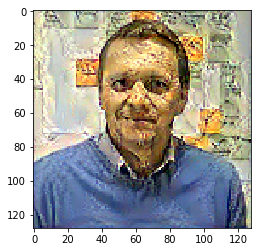

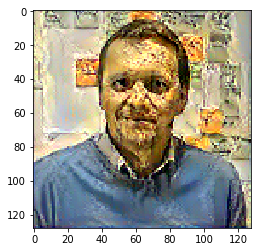

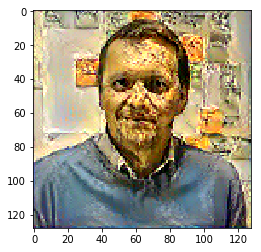

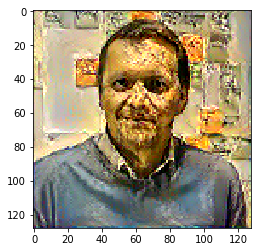

In [45]:
def imshow(img):
    r = img[0].numpy().transpose(1,2,0)
    plt.imshow(r)
    
#Начальное приближение
input_img = Variable(content_img.clone(),requires_grad=True)
#Оптимизатор
optimizer = optim.LBFGS([input_img])
#Собираем функци потерь для стиля
style_features = vgg(Variable(style_img))
style_losses = [StyleLoss(f) for f in style_features]
#Собираем функци потерь для содержания
content_features = vgg(Variable(content_img))
content_losses = [ContentLoss(f) for f in content_features[3:]]

run = [0]
while run[0] <= 200:
    def closure():
        run[0]+=1
        input_img.data.clamp_(0, 1)
        optimizer.zero_grad()
        current_features = vgg(input_img)
        #TODO посчитать ошибку стиля как сумму style_losses по current_features и сохрпнить в sl
        #sl = torch.sum([loss(feature) for loss, feature in zip(style_losses, current_features[:3])])
        cl,sl = torch.FloatTensor([0]), torch.FloatTensor([0])
        for loss, feature in zip(style_losses, current_features):
            sl +=loss(feature)
        #TODO посчитать ошибку содержания как сумму content_losses по current_features и сохрпнить в сl
        for loss, feature in zip(content_losses, current_features[3:]):
            cl +=loss(feature)
        #cl = torch.sum([loss(feature) for loss, feature in zip(content_losses, current_features[3:])])
        loss = 200000.*sl+cl
        loss.backward()
        if run[0]%50==0:
            imshow(input_img.data.clamp_(0, 1))
            plt.show()
        return loss
    optimizer.step(closure=closure)


In [40]:
current_features = vgg(input_img)

In [27]:
len(current_features)

5